# Proyecto Teoria de la Simulacion

##### Obejetivo de este proyecto 
###### Aprendan a manipular diccionarios  como una herramienta fundamental para configurar dataframestiva.

### Requisito 1:
 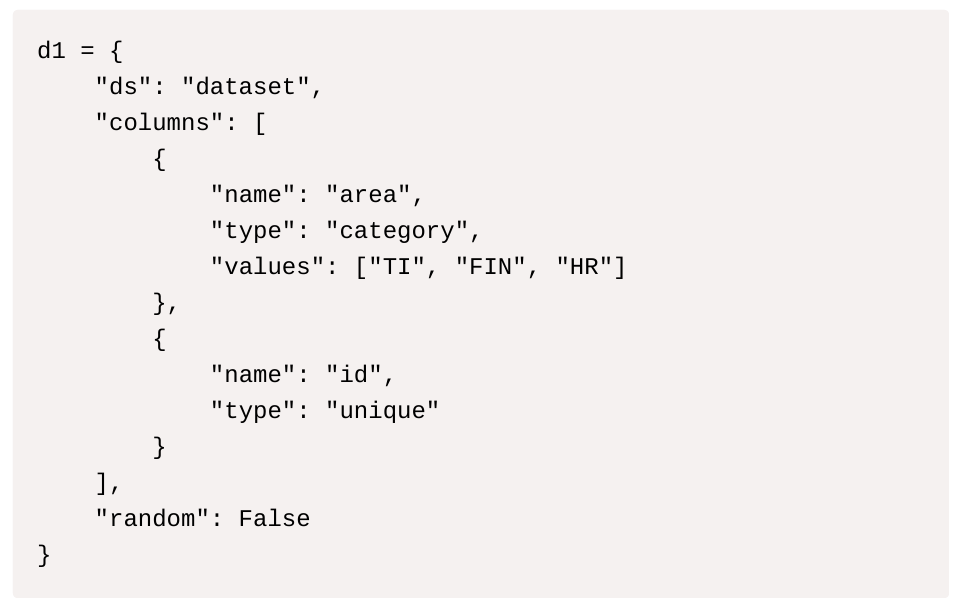
 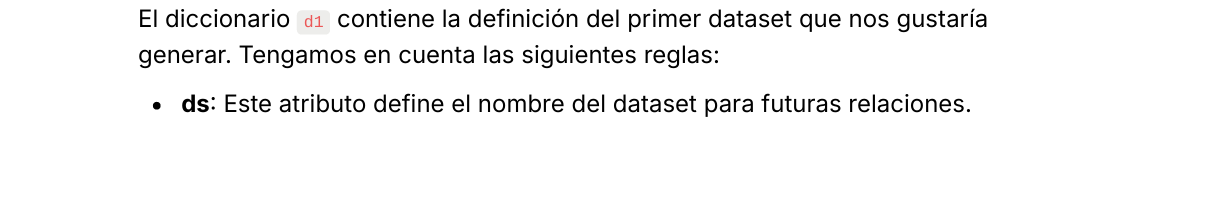
 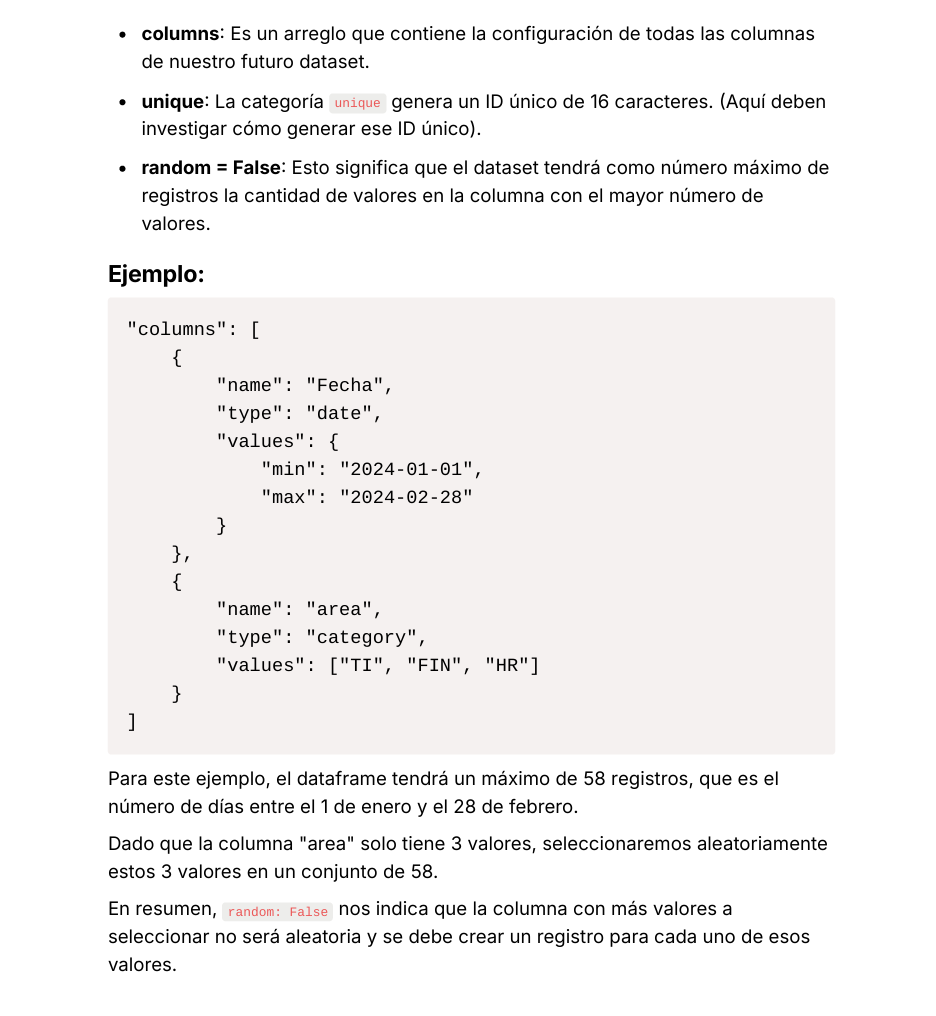
 

#### Primero las dependencias

In [1]:
import pandas as pd
import numpy as np
import random
import secrets # nos permite crear valores altamente impredecibles
import string
from scipy.stats import truncnorm # nos permite crear valores altamente con la distribucion probabilistica truncada

#### Traemos funciones ya conocidas hechas en clases, agregando el parametro random_=True

In [2]:
# n lo defino en 0 agregamos random_=True que nos permitira saber si los van a ser de forma random

# Obtiene una lista de categorías aleatorias o una lista fija de elementos
def get_random_categories( items , n=0,random_=True):
    if random_:
        return random.choices(items, k=n)
    else:
        return items

# Obtiene una lista de números aleatorios dentro de un rango especificado
def get_random_numbers( min , max, n=0,random_=True ):
    values = []
    for i in range(n):
        values.append(
            random.randint(min, max)
        )
    return values

# Obtiene una lista de fechas aleatorias dentro de un rango especificado
def get_random_dates( min , max , n=0,random_=True):
    items = pd.date_range( start = min , end = max , freq = 'D' )
    #agregamos la logica dependiendo si random_ es true or false
    if random_:
        return get_random_categories( items , n )
    else:
        return items
        

#### Creamos la funcion unique con ayuda de secrets.choice del tamaño deseado

In [3]:
# Genera un identificador único de la longitud especificada
def generate_unique_id(length=6):
    digits = string.digits
    return ''.join(secrets.choice(digits) for _ in range(length))  #'.join(...): Combina los caracteres seleccionados en una cadena, en 
                                                                   # nuestro caso seria la cadena de digitos aleatorios del tamaño(length)
                                                                   # deseado del id
# Genera una lista de valores únicos
def get_unique_values(count, length=6):
    unique_ids = set()
    while len(unique_ids) < count:
        new_id = generate_unique_id(length)  #generamos el id 
        if new_id not in unique_ids:  #validamos para no agregar un id que ya exista
            unique_ids.add(new_id)
    return list(unique_ids)


#### Generamos la logica para de "random" = flase

###### esta logica solo se va a ejecutar cuando random sea false, para lo cual crearemos una funcion que dado el sett nos extraiga la columna con mas datos

In [4]:
## retonar la candtidad maxima de items y el nombre de la columna con mas items(maxlenvalue,maxnamecolum)
def get_max_colum( sett ):
    types = [ 'category' , 'numeric' , 'date']
    maxlenvalue=0
    maxnamecolum=''
    for columns in sett['columns']:
        if columns["type"] in types:
            if columns['type'] == "category":
                currentlenvalue = len(columns['values'])# extraemos el las cantidad de items
                currentnamecolum= columns['name'] # extraemos el nombre de la columna
            if columns['type'] == "date":
                currentlenvalue = len(get_random_dates(columns['values']['min'], columns['values']['max'],0,False))# extraemos el las cantidad de items
                currentnamecolum= columns['name'] # extraemos el nombre de la columna
                
            if(currentlenvalue>maxlenvalue): # comapramos para quedarnos con la mayor de todas
                maxlenvalue=currentlenvalue
                maxnamecolum=currentnamecolum
    return maxlenvalue,maxnamecolum #retornamos los dos datos encontrados 
        

#### Para el dato foreign tenemos que defirnir una funcion nuevo

##### esta funcion es nesesaria para el requisito 2

In [5]:
# Obtiene valores de una columna de un dataset referenciado
def get_foreign_values(ref_ds_name, ref_col_name, datasets):
    if ref_ds_name not in datasets:
        raise ValueError(f"Dataset {ref_ds_name} no existe.")
    ref_dataset = datasets[ref_ds_name]
    if ref_col_name not in ref_dataset.columns:
        valid_columns = ', '.join(ref_dataset.columns)
        raise ValueError(f"Columna {ref_col_name} no existe en {ref_ds_name}. Columnas válidas: {valid_columns}")
    return ref_dataset[ref_col_name].tolist()


#### Para el dato random=true

##### esta funcion es nesesaria para el requisito 3, haremos uso de la generate_truncated_normal_data que fue programada en clase

In [6]:
# Genera datos con una distribución normal truncada
def generate_truncated_normal_data(mean, std, min_val, max_val, size):
    # Calcular los parámetros de la distribución normal truncada
    if std==0:
        std=1
        min_val=min_val-1
        max_val=max_val+1
    
    a, b = (min_val - mean) / std, (max_val - mean) / std
    data = truncnorm(a, b, loc=mean, scale=std).rvs(size)
    return data
    

#### Traemos la funcion get_dataframe hecha en clase, manteniendo la misma estructura logica pero agregando los nuevos requisitos

In [7]:
# Función principal para generar el dataframe basado en el 'sett' proporcionado
def get_dataframe(sett, num_records=0, datasets={}):
    metadata_df = {}

    types = [ 'category' , 'numeric' , 'date','unique','foreign' ] # tipos permirtidos

    ds=sett['ds']# extraemos el nombre del dataset
    
    randomClumnsTrueOrFalse=sett['random']## extraemos el dato de si ramdon es true or false
    
    if randomClumnsTrueOrFalse:
        num_records=sett['random_rows']
        maxnamecolum=''
    else:
        
        num_records,maxnamecolum=get_max_colum(sett)
        
        
    for columns in sett['columns']:
        
        if columns["type"] in types:
            if columns["name"]==maxnamecolum:
                randomClumnsTrueOrFalse=False
            else:
                randomClumnsTrueOrFalse=True

            # logica para el la tabla category
            if columns['type'] == "category":
                values = get_random_categories( columns['values'] , num_records,randomClumnsTrueOrFalse  )
            
            # logica para el la tabla unique
            if columns['type'] == "unique":
                values = get_unique_values(num_records)

            # logica para el la tabla date
            if columns['type'] == "date":
                values = get_random_dates(columns['values']['min'], columns['values']['max'], num_records,randomClumnsTrueOrFalse)
            
            # logica para el la tabla numeric, requisito 3
            if columns['type'] == "numeric":
                if all(k in columns['values'] for k in ('std', 'min', 'max', 'mean')):
                    values = generate_truncated_normal_data(
                        std=columns['values']['std'],
                        min_val=columns['values']['min'],
                        max_val=columns['values']['max'],
                        mean=columns['values']['mean'],
                        size=num_records
                    )
                elif all(k in columns['values'] for k in ('min', 'max')):
                    values = get_random_numbers(
                        min=columns['values']['min'],
                        max=columns['values']['max'],
                        n=num_records,
                        random_=True
                    )
            # logica para el la tabla foreign, requisito 2
            if columns['type'] == "foreign":
                ref_ds_name, ref_col_name = columns['values'].split('.')
                values = get_random_categories(get_foreign_values(ref_ds_name, ref_col_name, datasets), num_records, randomClumnsTrueOrFalse)               
        metadata_df[columns['name']] = values
        

        df=pd.DataFrame( metadata_df )
        
        df.name=ds #agregamos el nombre al dataset
        datasets[ds] = df  # Guardar el dataset en el diccionario de datasets
    return df


#### comprobamos requisito 1

In [8]:
d1 = {
    "ds": "dataset",
     "columns": [
         {
             "name": "Fecha",
             "type": "date",
             "values": {
                 "min": "2024-01-01",
                 "max": "2024-02-28"
             }
         },
         {
             "name": "area",
             "type": "category",
             "values": ["TI", "FIN", "HR"]
         }
     ],
    "random": False
 }

In [9]:
df = get_dataframe(d1)
print(f"Dataset Name: {df.name}")

Dataset Name: dataset


In [10]:
df

,Fecha,area
0,2024-01-01,TI
1,2024-01-02,TI
2,2024-01-03,HR
3,2024-01-04,HR
4,2024-01-05,TI
5,2024-01-06,HR
6,2024-01-07,TI
7,2024-01-08,TI
8,2024-01-09,HR
9,2024-01-10,FIN


## Requisito 2:
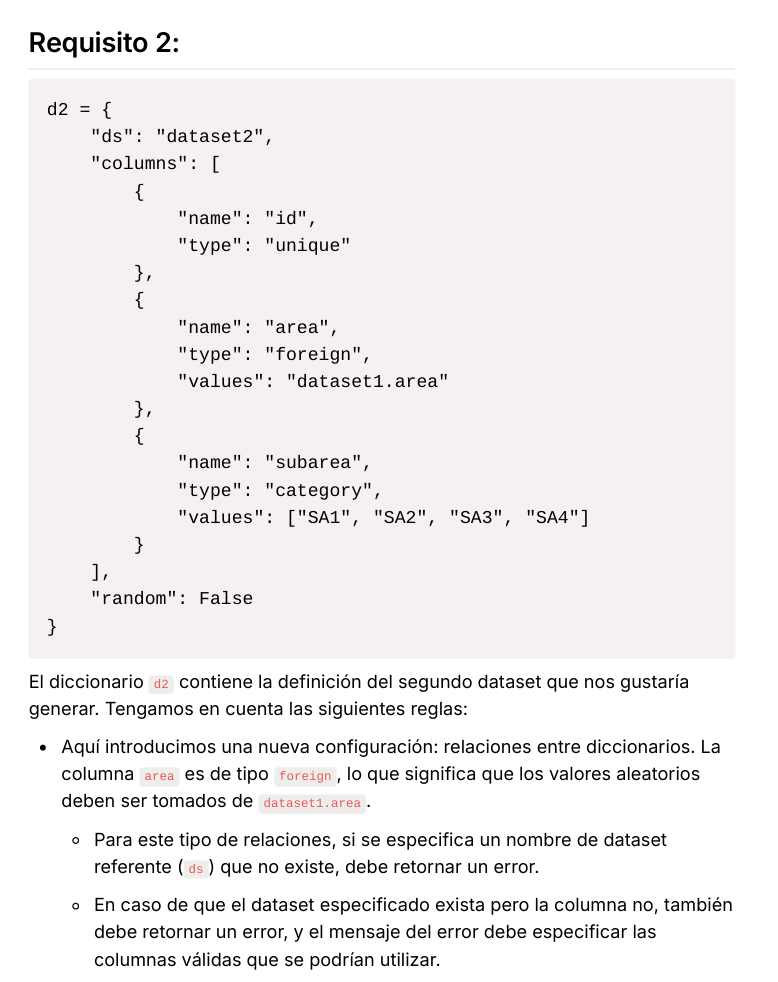
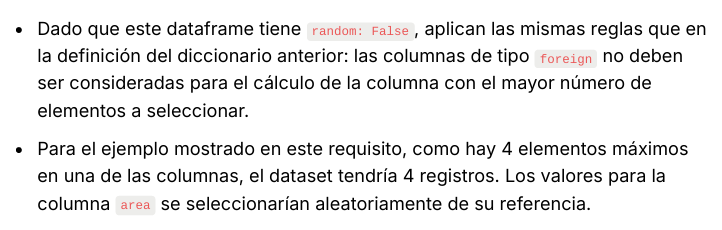

### comprobamos requisito 2

In [11]:
d1 = {
    "ds": "dataset1",
    "columns": [
        {
            "name": "Fecha",
            "type": "date",
            "values": {
                "min": "2024-01-01",
                "max": "2024-02-28"
            }
        },
        {
            "name": "area",
            "type": "category",
            "values": ["TI", "FIN", "HR"]
        }
    ],
    "random": False
}
d2 = {
    "ds": "dataset2",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "area",
            "type": "foreign",
            "values": "dataset1.area"
        },
        {
            "name": "subarea",
            "type": "category",
            "values": ["SA1", "SA2", "SA3", "SA4"]
        }
    ],
    "random": False
}

In [12]:
datasets = {}
df1 = get_dataframe(d1, datasets=datasets)
df2 = get_dataframe(d2, datasets=datasets)

print(f"Dataset Name: {df1.name}")
print(df1)

print(f"Dataset Name: {df2.name}")
print(df2)


Dataset Name: dataset1
        Fecha area
0  2024-01-01  FIN
1  2024-01-02  FIN
2  2024-01-03   HR
3  2024-01-04   HR
4  2024-01-05  FIN
5  2024-01-06  FIN
6  2024-01-07   HR
7  2024-01-08   HR
8  2024-01-09  FIN
9  2024-01-10   HR
10 2024-01-11   TI
11 2024-01-12  FIN
12 2024-01-13   HR
13 2024-01-14   TI
14 2024-01-15   HR
15 2024-01-16  FIN
16 2024-01-17   HR
17 2024-01-18  FIN
18 2024-01-19   TI
19 2024-01-20   HR
20 2024-01-21   HR
21 2024-01-22   TI
22 2024-01-23  FIN
23 2024-01-24   TI
24 2024-01-25  FIN
25 2024-01-26  FIN
26 2024-01-27  FIN
27 2024-01-28  FIN
28 2024-01-29   HR
29 2024-01-30   HR
30 2024-01-31  FIN
31 2024-02-01   TI
32 2024-02-02   TI
33 2024-02-03   TI
34 2024-02-04  FIN
35 2024-02-05   HR
36 2024-02-06  FIN
37 2024-02-07   TI
38 2024-02-08   TI
39 2024-02-09  FIN
40 2024-02-10   HR
41 2024-02-11   HR
42 2024-02-12   TI
43 2024-02-13   HR
44 2024-02-14   TI
45 2024-02-15   HR
46 2024-02-16   HR
47 2024-02-17  FIN
48 2024-02-18   TI
49 2024-02-19   HR
50 2024-

## Requisito 3:
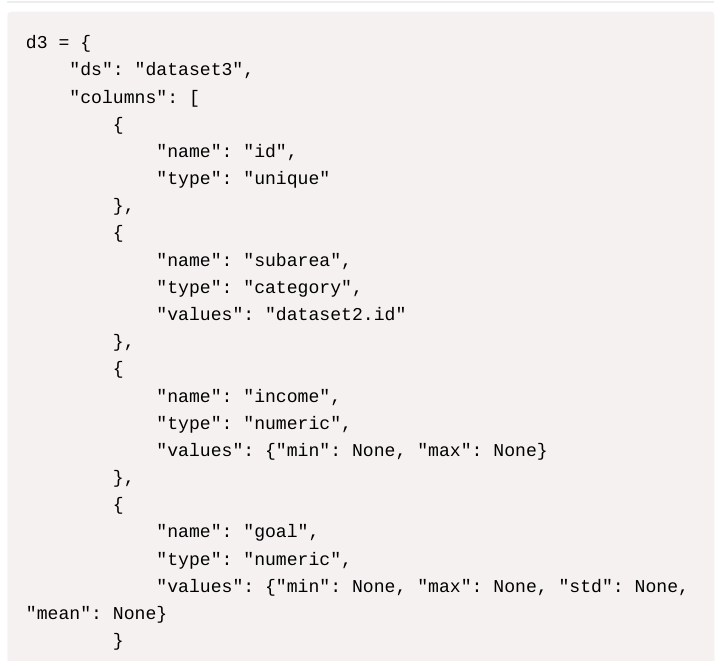
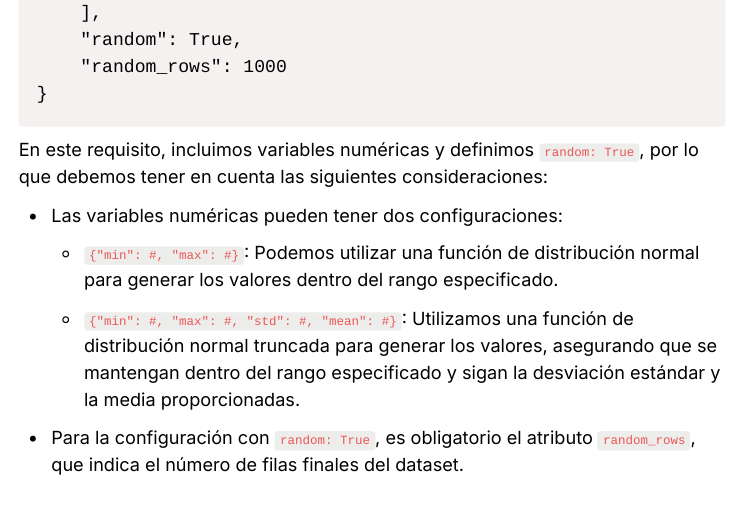

### comprobamos requisito 3

In [13]:
d3 = {
    "ds": "dataset3",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "subarea",
            "type": "foreign",
            "values": "dataset2.id"
        },
        {
            "name": "income",
            "type": "numeric",
            "values": {"min": 5, "max": 7}
        },
        {
            "name": "goal",
            "type": "numeric",
            "values": {"min": 1, "max": 15, "std": 0.993, "mean": 5}
        }
    ],
    "random": True,
    "random_rows": 1000
 }

In [14]:
df3 = get_dataframe(d3, datasets=datasets)

In [15]:
df3

,id,subarea,income,goal
0,910968,174683,6,6.036327
1,735729,359621,6,6.289493
2,085933,772663,5,6.562456
3,135003,804744,7,4.441244
4,606306,804744,7,4.582138
...,...,...,...,...
995,595654,174683,7,5.504451
996,700961,174683,6,4.659006
997,339866,174683,7,3.803082
998,303912,804744,7,5.332302


## Requisito 4

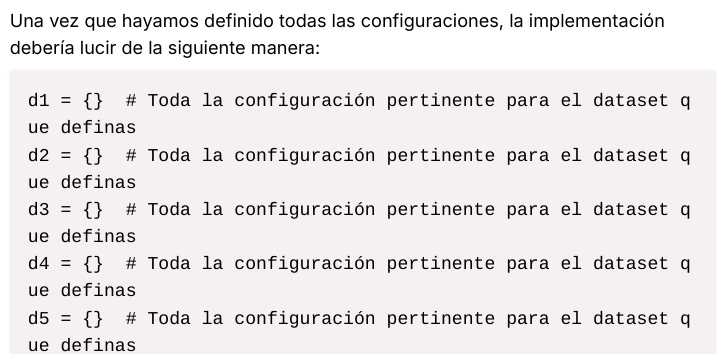
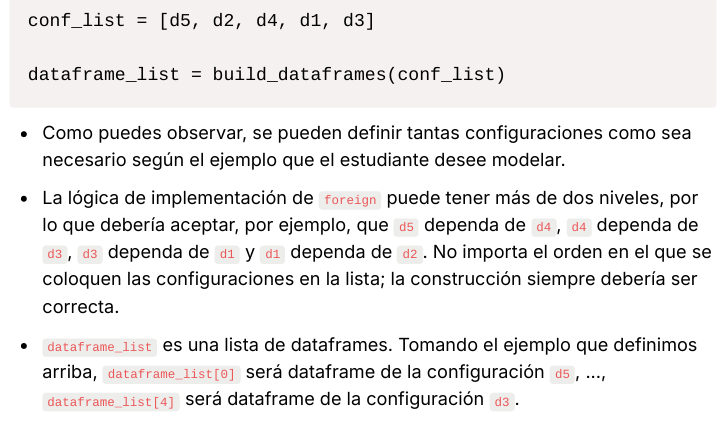

### crearemos una funcion que nos permita trabar con las funciones antes creadas

In [16]:
def build_dataframes(config_list):
    # Crear una lista de dependencias para cada configuración
    dependencies = {}
    for config in config_list:
        dependencies[config['ds']] = []

    for config in config_list:
        for column in config['columns']:
            if column['type'] == 'foreign':
                ref_ds_name, _ = column['values'].split('.')
                dependencies[config['ds']].append(ref_ds_name)

    # Crear los dataframes en desorden
    datasets = {}
    while dependencies:
        # Encontrar las configuraciones que no tienen dependencias
        independent_configs = []
        for ds, deps in dependencies.items():
            if not deps:
                independent_configs.append(ds)

        # Si no se encuentran configuraciones independientes, hay un problema de dependencias cíclicas o no resueltas
        if not independent_configs:
            raise ValueError("Hay una dependencia cíclica o no resuelta en las configuraciones")

        # Crear dataframes para las configuraciones independientes y actualizarlas en el diccionario de datasets
        for ds_name in independent_configs:
            config = next(config for config in config_list if config['ds'] == ds_name)
            get_dataframe(config, datasets=datasets)
            del dependencies[ds_name]

        # Eliminar las dependencias resueltas de las otras configuraciones
        for ds_name in dependencies:
            new_deps = []
            for dep in dependencies[ds_name]:
                if dep not in independent_configs:
                    new_deps.append(dep)
            dependencies[ds_name] = new_deps

    # Crear la lista de dataframes en el orden correcto
    dataframe_list = []
    for config in config_list:
        dataframe_list.append(datasets[config['ds']])
    
    return dataframe_list

### Comprobación del requisito 4

In [17]:
d1 = {
    "ds": "dataset1",
    "columns": [
        {
            "name": "Fecha",
            "type": "date",
            "values": {
                "min": "2024-01-01",
                "max": "2024-02-28"
            }
        },
        {
            "name": "area",
            "type": "category",
            "values": ["TI", "FIN", "HR"]
        }
    ],
    "random": False
}

d2 = {
    "ds": "dataset2",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "area",
            "type": "foreign",
            "values": "dataset1.area"
        },
        {
            "name": "subarea",
            "type": "category",
            "values": ["SA1", "SA2", "SA3", "SA4"]
        }
    ],
    "random": False
}

d3 = {
    "ds": "dataset3",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "subarea",
            "type": "foreign",
            "values": "dataset2.id"
        },
        {
            "name": "income",
            "type": "numeric",
            "values": {"min": 5, "max": 7}
        },
        {
            "name": "goal",
            "type": "numeric",
            "values": {"min": 1, "max": 15, "std": 0.993, "mean": 5}
        }
    ],
    "random": True,
    "random_rows": 1000
}

d4 = {
    "ds": "dataset4",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "team",
            "type": "category",
            "values": ["TeamQueso", "TeamPizza", "TeamAlitas"]
        }
    ],
    "random": False
}

d5 = {
    "ds": "dataset5",
    "columns": [
        {
            "name": "project",
            "type": "unique"
        },
        {
            "name": "team_id",
            "type": "foreign",
            "values": "dataset4.id"
        }
    ],
    "random": True,
    "random_rows": 100
}


In [ ]:
# Lista de configuraciones
conf_list = [ d5,d2, d4, d1, d3]

# Construir los dataframes
dataframe_list = build_dataframes(conf_list)

# Mostrar los dataframes creados
for df in dataframe_list:
    print(df.name)
    print(df.head())

### Requisito 5

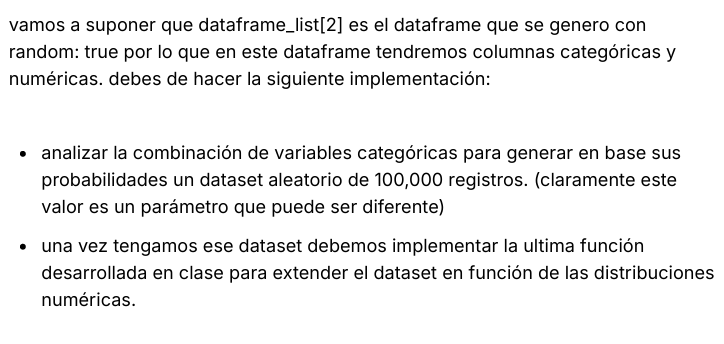
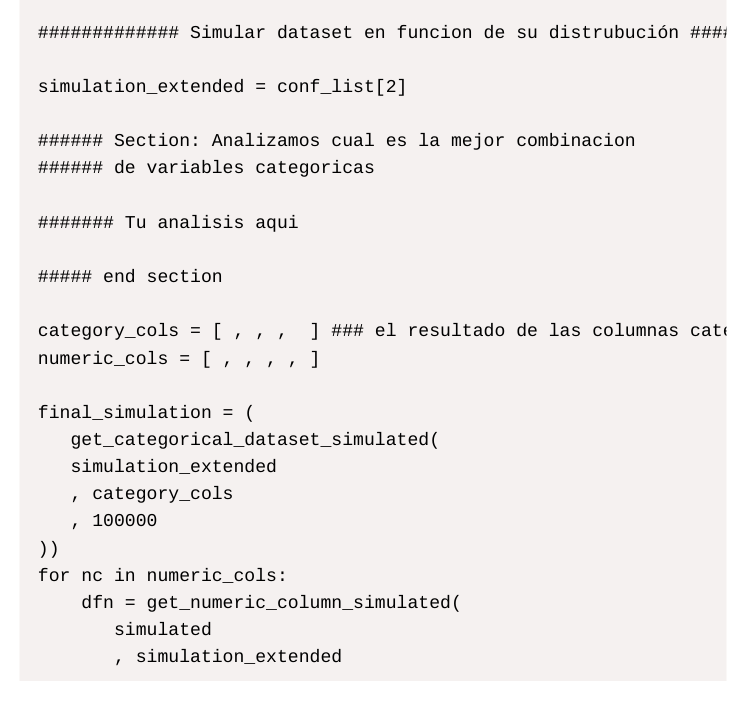

In [65]:
d1 = {
    "ds": "dataset1",
    "columns": [
        {
            "name": "Fecha",
            "type": "date",
            "values": {
                "min": "2024-01-01",
                "max": "2024-02-28"
            }
        },
        {
            "name": "area",
            "type": "category",
            "values": ["TI", "FIN", "HR"]
        }
    ],
    "random": False
}

d2 = {
    "ds": "dataset2",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "area",
            "type": "foreign",
            "values": "dataset1.area"
        },
        {
            "name": "subarea",
            "type": "category",
            "values": ["SA1", "SA2", "SA3", "SA4"]
        }
    ],
    "random": False
}

d3 = {
    "ds": "dataset3",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "subarea",
            "type": "foreign",
            "values": "dataset2.id"
        },
        {
            "name": "income",
            "type": "numeric",
            "values": {"min": 5, "max": 7}
        },
        {
            "name": "goal",
            "type": "numeric",
            "values": {"min": 1, "max": 15, "std": 0.993, "mean": 5}
        }
    ],
    "random": True,
    "random_rows": 10
}

d4 = {
    "ds": "dataset4",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "fecha",
            "type": "date",
            "values": {
                "min": "2024-03-01",
                "max": "2024-04-30"
            }
        },
        {
            "name": "valor",
            "type": "numeric",
            "values": {"min": 10, "max": 20}
        }
    ],
    "random": True,
    "random_rows": 500
}

d5 = {
    "ds": "dataset5",
    "columns": [
        {
            "name": "clase",
            "type": "category",
            "values": ["A", "B", "C"]
        },
        {
            "name": "Sabor de Dulse",
            "type": "category",
            "values": ["mango", "uva", "fresa","mora","arandano"]
        },
        {
            "name": "cantidad",
            "type": "numeric",
            "values": {"min": 70, "max": 100}
        },
        {
            "name": "Precio",
            "type": "numeric",
            "values": {"min": 5, "max": 25}
        },
        {
            "name": "id_Dset3",
            "type": "foreign",
            "values": "dataset3.id"
        }
    ],
    "random": True,
    "random_rows": 1000
}

conf_list = [d2, d5, d4, d1, d3]
dataframe_list = build_dataframes(conf_list)

In [119]:
simulation_extended = conf_list[1]
df=dataframe_list[1]

### Analicis de las distribucion

In [67]:
dataframe_list[1]

,clase,Sabor de Dulse,cantidad,Precio,id_Dset3
0,C,mango,82,8,894313
1,B,mora,86,7,901901
2,B,uva,87,17,282120
3,A,arandano,81,16,282120
4,B,uva,88,11,159737
...,...,...,...,...,...
995,B,mora,81,14,901901
996,A,mora,97,7,186160
997,A,arandano,86,6,317017
998,B,mora,82,10,282120


In [88]:
firstAgg = (
    dataframe_list[1]
    .groupby( [
         "clase"
        , "Sabor de Dulse"
        ,"id_Dset3"
    ] , as_index=False )

    .agg({
        "cantidad": ["count"]
    })
)

In [89]:
firstAgg

,clase,Sabor de Dulse,id_Dset3,cantidad
,,,,count
0,A,arandano,159737,2
1,A,arandano,161207,6
2,A,arandano,175151,4
3,A,arandano,186160,11
4,A,arandano,282120,7
...,...,...,...,...
145,C,uva,283765,6
146,C,uva,317017,6
147,C,uva,894313,7


In [90]:
firstAgg.columns = [        
        "clase"
        , "Sabor de Dulse"
        , "id_Dset3"
        , "Count"
]

In [91]:
firstAgg['prob'] = firstAgg['Count'] / df.shape[0]

In [105]:
firstAgg

,clase,Sabor de Dulse,id_Dset3,Count,prob
0,A,arandano,159737,2,0.002
1,A,arandano,161207,6,0.006
2,A,arandano,175151,4,0.004
3,A,arandano,186160,11,0.011
4,A,arandano,282120,7,0.007
...,...,...,...,...,...
145,C,uva,283765,6,0.006
146,C,uva,317017,6,0.006
147,C,uva,894313,7,0.007
148,C,uva,901901,5,0.005


In [102]:
firstAgg['prob']

0      0.002
1      0.006
2      0.004
3      0.011
4      0.007
       ...  
145    0.006
146    0.006
147    0.007
148    0.005
149    0.009
Name: prob, Length: 150, dtype: float64

### una vez hecho este pequeño analisis procecedemos a crear y traer las funciones que nos faltan

In [185]:
def get_categorical_dataset_simulated(simulation_extended,df,category_cols,n):
    simulation_extended["columns"][2]
    cols=""
    for c in simulation_extended["columns"]:
        if(c["type"]=="numeric"):
            cols=c["name"]
    

    simulatedConf = (
    dataframe_list[1]
    .groupby( category_cols , 
             as_index=False )

    .agg({
        cols: ["count"]
    })
    )
    new_category_cols=category_cols.copy()
    new_category_cols.append("Count")
    simulatedConf.columns = new_category_cols

    simulatedConf['prob'] = simulatedConf['Count'] / df.shape[0]
    
    randIndex = np.random.choice( simulatedConf.index , size=n , p = list(simulatedConf['prob']))
    simulated  = simulatedConf.loc[ randIndex , category_cols ]
    
    return simulated
    
    

In [186]:
def get_numeric_column_simulated( simulated , df_origin , categories , column_name ):

    a1 = df_origin.groupby(
        categories
        , as_index = False
    ).agg(
        {
            column_name: ["min","max","mean","std"]
        }
    )
    nc = [ c for c in categories ]
    nc.extend( ["Min" , "Max" , "Mean" , "Std"] )
    a1.columns = nc

    ColumnSimulated = pd.DataFrame()
    for i in a1.index:
        rs = a1.loc[i]
        OneSegmnetCountryProduct = simulated.loc[i].copy()    
    
        data = generate_truncated_normal_data(
            rs["Mean"]
            , 1 if rs["Std"] == 0 else rs["Std"]
            , rs["Min"] - 1 if rs["Std"] == 0 else rs["Min"]
            , rs["Max"] + 1 if rs["Std"] == 0 else rs["Max"]
            , OneSegmnetCountryProduct.shape[0]
        )
    
        OneSegmnetCountryProduct[column_name] = data
    
        ColumnSimulated = pd.concat( [ ColumnSimulated , OneSegmnetCountryProduct  ] )

    return ColumnSimulated.reset_index(drop=True)
    

In [187]:
category_cols = [ "clase" , "Sabor de Dulse" , "id_Dset3" ] ### el resultado de las columnas cate
numeric_cols = [ "cantidad","Precio"]

final_simulation = (
    get_categorical_dataset_simulated( 
        simulation_extended
        ,df
        , category_cols 
        , 100000 
)).sort_index().reset_index(drop=True).copy()



In [188]:
final_simulation

,clase,Sabor de Dulse,id_Dset3
0,A,arandano,159737
1,A,arandano,159737
2,A,arandano,159737
3,A,arandano,159737
4,A,arandano,159737
...,...,...,...
99995,C,uva,961305
99996,C,uva,961305
99997,C,uva,961305
99998,C,uva,961305


In [189]:
for nc in numeric_cols:
    dfn = get_numeric_column_simulated( 
        simulated 
        , df
        , category_cols 
        , nc
    ).sort_index().reset_index(drop=True).copy()
    final_simulation = pd.merge( final_simulation , dfn.loc[ : , [nc] ] , left_index=True , right_index=True )
    
print( final_simulation)

      clase Sabor de Dulse id_Dset3   cantidad     Precio
0         A       arandano   159737  94.020140   8.540966
1         A       arandano   159737  92.823380  15.168592
2         A       arandano   159737  94.887292   7.061037
3         A       arandano   159737  96.444907  12.997613
4         A       arandano   159737  92.337186   5.509572
...     ...            ...      ...        ...        ...
99995     C            uva   961305  78.048334  20.084698
99996     C            uva   961305  83.175073  21.035059
99997     C            uva   961305  76.562672   8.614250
99998     C            uva   961305  75.669712  19.450120
99999     C            uva   961305  89.480555  15.374995

[100000 rows x 5 columns]
